## Interesting Visulizations
### Return the top-k interesting visulaizations from any database!
#### Submmitters: Ido Tausi, Afek Nahum

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency, spearmanr, entropy
from sklearn.preprocessing import LabelEncoder


In [274]:

# Importing the dataset
# dataset = pd.read_csv('StudentsDepression.csv')
target_column = 'Depression'

dataset = pd.read_csv('heart_attack_risk_dataset.csv')
target_column = 'Heart_Attack_Risk'
dataset.head()
dataset[target_column].value_counts()
if target_column == 'Depression':
    dataset = dataset.drop(columns=['Profession', 'Work Pressure', 'Job Satisfaction', 'City'])
elif target_column == 'Heart_Attack_Risk':
    # dataset = dataset.drop(columns=['Accident_Index', 'Accident Date'])
    # dataset = dataset.head(100000)
    pass


In [275]:
def fill_missing_values(dataset):
    for column in dataset.columns:
        # print(f'{column} data type: {dataset[column].dtype}, is_numeric: {pd.api.types.is_numeric_dtype(dataset[column])}')
        if pd.api.types.is_numeric_dtype(dataset[column]):
            dataset.fillna(dataset[column].mean(), inplace=True)

    return dataset

fill_missing_values(dataset)



,Age,Gender,Smoking,Alcohol_Consumption,Physical_Activity_Level,BMI,Diabetes,Hypertension,Cholesterol_Level,Resting_BP,Heart_Rate,Family_History,Stress_Level,Chest_Pain_Type,Thalassemia,Fasting_Blood_Sugar,ECG_Results,Exercise_Induced_Angina,Max_Heart_Rate_Achieved,Heart_Attack_Risk
0,69,Female,1,0,Moderate,34.61,1,0,152.1,171,85,0,Moderate,Non-anginal,Reversible defect,0,Normal,0,114,Low
1,32,Male,0,0,Moderate,22.75,0,0,166.8,126,103,0,Low,Asymptomatic,Normal,0,ST-T abnormality,0,173,Moderate
2,89,Male,0,1,Moderate,35.32,0,0,272.3,123,127,0,Low,Typical,Reversible defect,0,ST-T abnormality,0,109,Low
3,78,Male,0,1,Moderate,18.23,1,0,237.7,144,125,0,Low,Typical,Fixed defect,1,Left Ventricular Hypertrophy,0,129,Low
4,38,Female,1,0,Moderate,19.82,0,0,207.7,123,107,0,High,Asymptomatic,Reversible defect,0,ST-T abnormality,0,124,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,21,Male,0,0,Low,39.93,0,0,269.9,171,113,0,High,Typical,Reversible defect,0,ST-T abnormality,0,122,High
49996,35,Female,0,0,Low,18.10,0,0,235.8,146,71,0,Moderate,Non-anginal,Fixed defect,1,ST-T abnormality,0,121,Moderate
49997,46,Male,0,1,High,21.42,0,0,172.8,146,85,1,Low,Typical,Fixed defect,0,Left Ventricular Hypertrophy,0,125,Low
49998,56,Male,0,1,Low,29.93,0,0,244.1,151,110,0,Low,Asymptomatic,Reversible defect,0,Normal,0,149,Moderate


In [293]:
def bin_numerical_columns(dataframe):
    binned_cloumns = []
    dataframe = dataframe.copy()
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            
            # remove outliers
            # q1 = dataframe[column].quantile(0.25)
            # q3 = dataframe[column].quantile(0.75)
            # iqr = q3 - q1
            # lower_bound = q1 - 1.5 * iqr
            # upper_bound = q3 + 1.5 * iqr
            # dataframe = dataframe[(dataframe[column] > lower_bound) & (dataframe[column] < upper_bound)]
            if dataframe[column].nunique() < 10:
                continue
            # TODO: decide on bins sizes
            bins_number = 30
            dataframe[column] = pd.cut(dataframe[column], bins=bins_number, right=True)
            binned_cloumns.append(column)
    return dataframe, binned_cloumns


In [294]:
def subset_data(dataframe, column, value):
    return dataframe[dataframe[column] == value]

def create_subsets_for_column(dataframe, column, subset_threshold=10):
    subsets = {}
    for value, count in dataframe[column].value_counts().items():
        # print(f'{value}: {count}')
        if count < subset_threshold:
            continue
        subsets[value] = subset_data(dataframe, column, value)
    return subsets

def create_subsets(dataframe, columns):
    subsets = {}
    for column in columns:
        # TODO: calculate subset threshold
        subsets[column] = create_subsets_for_column(dataframe, column)
    return subsets

binned_dataset, binned_columns = bin_numerical_columns(dataset)


binned_dataset[target_column].value_counts()
# 
# subsets = {
#     "Age": {
#         (18, 20]: dataframe,
#         (20, 22]: dataframe,
#         ...
#     },
#     "CGPA": {
#         (6.5, 7.0]: dataframe,
#         (7.0, 7.5]: dataframe,
#         ...
#     },
#     ...
# }

Heart_Attack_Risk
Low         25024
Moderate    14904
High        10072
Name: count, dtype: int64

In [295]:
def map_column_values(dataframe, column_names, mappings):
    dataframe = dataframe.copy()
    for column_name, mapping in zip(column_names, mappings):
        dataframe[column_name] = dataframe[column_name].map(mapping)
    return dataframe
if target_column == 'Depression':
    sleep_duration_map = {
        'Less than 5 hours': 1,
        '5-6 hours': 2,
        '7-8 hours': 3,
        'More than 8 hours': 4,
        'Others': 5 
    }

    dietary_habits_map = {
        'Healthy': 1,
        'Moderate': 2,
        'Unhealthy': 3,
        'Others': 4
    }

    gender_map = {
        'Male': 1,
        'Female': 0
    }

    suicidal_thoughts_map = {
        'Yes': 1,
        'No': 0
    }

    history_of_mental_health_map = {
        'Yes': 1,
        'No': 0
    }


    map_of_binned_columns = {}
    for bin_column in binned_columns:
        map_of_binned_columns[bin_column] = {}
        for interval_key in binned_dataset[bin_column].value_counts().keys():
            map_of_binned_columns[bin_column][interval_key] = round(interval_key.mid)


    binned_dataset = map_column_values(binned_dataset, column_names=['Sleep Duration', 'Dietary Habits', 'Gender', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'], 
                                    mappings=[sleep_duration_map, dietary_habits_map, gender_map, suicidal_thoughts_map, history_of_mental_health_map])

    binned_dataset = map_column_values(binned_dataset, column_names=binned_columns, mappings=[map_of_binned_columns[column] for column in binned_columns])

elif target_column == 'Heart_Attack_Risk':

    map_risk = {
        'Low': 1,
        'Moderate': 2,
        'High': 3
    }

    map_stress = {
        'Low': 1,
        'Moderate': 2,
        'High': 3
    }

    map_Physical_Activity_Level = {
        'Low': 1,
        'Moderate': 2,
        'High': 3
    }

    map_of_binned_columns = {}
    for bin_column in binned_columns:
        map_of_binned_columns[bin_column] = {}
        for interval_key in binned_dataset[bin_column].value_counts().keys():
            map_of_binned_columns[bin_column][interval_key] = round(interval_key.mid)

    binned_dataset = map_column_values(binned_dataset, column_names=['Heart_Attack_Risk', 'Stress_Level', 'Physical_Activity_Level'], mappings=[map_risk, map_stress, map_Physical_Activity_Level])
    
    binned_dataset = map_column_values(binned_dataset, column_names=binned_columns, mappings=[map_of_binned_columns[column] for column in binned_columns])
binned_dataset.head()


,Age,Gender,Smoking,Alcohol_Consumption,Physical_Activity_Level,BMI,Diabetes,Hypertension,Cholesterol_Level,Resting_BP,Heart_Rate,Family_History,Stress_Level,Chest_Pain_Type,Thalassemia,Fasting_Blood_Sugar,ECG_Results,Exercise_Induced_Angina,Max_Heart_Rate_Achieved,Heart_Attack_Risk
0,69,Female,1,0,2,35,1,0,152,172,84,0,2,Non-anginal,Reversible defect,0,Normal,0,115,1
1,31,Male,0,0,2,23,0,0,168,127,103,0,1,Asymptomatic,Normal,0,ST-T abnormality,0,174,2
2,88,Male,0,1,2,35,0,0,272,124,128,0,1,Typical,Reversible defect,0,ST-T abnormality,0,108,1
3,78,Male,0,1,2,18,1,0,238,145,126,0,1,Typical,Fixed defect,1,Left Ventricular Hypertrophy,0,128,1
4,38,Female,1,0,2,20,0,0,208,124,107,0,3,Asymptomatic,Reversible defect,0,ST-T abnormality,0,125,2


In [296]:
def get_subsets_correlations(dataframe, target_column):
    correlations = {}
    subsets = create_subsets(dataframe, dataframe.columns)
    for filter_column, filtered_subsets in subsets.items():
        if filter_column == target_column:
            continue
        for subset_key, subset in filtered_subsets.items():
            if subset.shape[0] < 50:
                continue
            for column in subset.columns:
                if column == target_column or column == filter_column:
                    continue
                if pd.api.types.is_numeric_dtype(subset[column]):
                    correlation, p_value = spearmanr(subset[column], subset[target_column])
                    if p_value < 0.05:
                        # TODO: note the correlation is positive or negative
                        correlations[(filter_column, subset_key, column)] = correlation
    
    top_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    return top_correlations


def get_column_correlations(dataframe, target_column, mappings={}):
    correlations = {}
    for column in dataframe.columns:
        if column == target_column:
            continue
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            correlation, _ = spearmanr(dataframe[column], dataframe[target_column])
            correlations[column] = correlation
    return correlations

def get_k_top_different_from_overall_correlations(dataframe, target_column, k=10):
    results = {}
    correlations = get_column_correlations(dataframe, target_column)
    subsets_correlations = get_subsets_correlations(dataframe, target_column)
    for (filter_column, subset_key, column), correlation in subsets_correlations:
        results[(filter_column, subset_key, column)] = {'correlation': correlation, 'overall_correlation': correlations[column],
                                                        'difference': abs(correlation - correlations[column])}
    top_correlations = sorted(results.items(), key=lambda x: x[1]['difference'], reverse=True)
    return top_correlations[:k]

def get_k_top_subset_correlations(dataframe, target_column, k=10):
    results = {}
    subsets_correlations = get_subsets_correlations(dataframe, target_column)
    for (filter_column, subset_key, column), correlation in subsets_correlations:
        results[(filter_column, subset_key, column)] = correlation
    top_correlations = sorted(results.items(), key=lambda x: abs(x[1]), reverse=True)
    return top_correlations[:k]



In [297]:
get_k_top_different_from_overall_correlations(binned_dataset, target_column, k=10)


[(('Heart_Rate', 109, 'Alcohol_Consumption'),
  {'correlation': 0.0927077709862501,
   'overall_correlation': 0.004998848518908901,
   'difference': 0.0877089224673412}),
 (('Heart_Rate', 89, 'Physical_Activity_Level'),
  {'correlation': 0.08523305237482913,
   'overall_correlation': -0.00041783131436816227,
   'difference': 0.0856508836891973}),
 (('Max_Heart_Rate_Achieved', 158, 'Smoking'),
  {'correlation': 0.0857170689581462,
   'overall_correlation': 0.004106551021032945,
   'difference': 0.08161051793711326}),
 (('Heart_Rate', 70, 'Fasting_Blood_Sugar'),
  {'correlation': 0.07975765231219456,
   'overall_correlation': -0.0008466668475028932,
   'difference': 0.08060431915969746}),
 (('Age', 36, 'Fasting_Blood_Sugar'),
  {'correlation': -0.08040801066412415,
   'overall_correlation': -0.0008466668475028932,
   'difference': 0.07956134381662125}),
 (('Resting_BP', 175, 'Exercise_Induced_Angina'),
  {'correlation': -0.07978142361492778,
   'overall_correlation': -0.00232012558409733

In [310]:
get_k_top_subset_correlations(binned_dataset, target_column, k=10)

[(('Heart_Rate', 109, 'Alcohol_Consumption'), 0.0927077709862501),
 (('Max_Heart_Rate_Achieved', 158, 'Smoking'), 0.0857170689581462),
 (('Heart_Rate', 89, 'Physical_Activity_Level'), 0.08523305237482913),
 (('Age', 36, 'Fasting_Blood_Sugar'), -0.08040801066412415),
 (('Resting_BP', 175, 'Exercise_Induced_Angina'), -0.07978142361492778),
 (('Heart_Rate', 70, 'Fasting_Blood_Sugar'), 0.07975765231219456),
 (('Heart_Rate', 107, 'Family_History'), -0.0737527264515714),
 (('Max_Heart_Rate_Achieved', 158, 'Fasting_Blood_Sugar'),
  0.07302806367530763),
 (('Cholesterol_Level', 208, 'Stress_Level'), -0.07172613068745769),
 (('Heart_Rate', 66, 'Smoking'), 0.07135282995688359)]

## Optimizations

#### Highest correlations mode, optimized:
- Firstly, we can calculate Entropy score for each columns, and take the top-N to make the subsets from.
- From those columns, we take the top-M columns with highest correlation to the target column.
- Now calculate subset correlation between each of top-M columns.

#### Biggest difference correlations mode, optimized:
- As before, we can calculate Entropy score for each columns, and take the top-N to make the subsets from.
- Now, we would check 2 methods:
    1. From those columns, we take the top-M columns with highest absoulute correlation to the target column.
    2. From those columns, we take the top-M columns with lowest correlation to the target column.
    3. We take the top-M columns with lowest correlation to the target column.
- Now calculate subset correlation between each of top-M columns.


In [299]:
def top_n_entropy_columns(dataframe, target_column, n=10):
    results = {}
    for column in dataframe.columns:
        if column == target_column:
            continue
        prob_distribution = dataframe[column].value_counts(normalize=True)
        results[column] = entropy(prob_distribution)
    top_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
    return top_results[:n]

top_n_entropy_columns(binned_dataset, target_column, n=10)

[('Resting_BP', 3.400995096673793),
 ('Cholesterol_Level', 3.4008422668817655),
 ('Max_Heart_Rate_Achieved', 3.391129465992531),
 ('Heart_Rate', 3.383650765325524),
 ('Age', 3.381366151820574),
 ('BMI', 3.215559068417652),
 ('Chest_Pain_Type', 1.386265843834643),
 ('ECG_Results', 1.0985949434278917),
 ('Thalassemia', 1.0985894062770727),
 ('Physical_Activity_Level', 1.054152798913222)]

In [300]:
def get_subsets_correlations_optimized(dataframe, target_column, entropy_columns, chosen_corr_columns):
    correlations = {}
    subsets = create_subsets(dataframe, entropy_columns)
    
    for filter_column, filtered_subsets in subsets.items():
        if filter_column == target_column:
            continue
        for subset_key, subset in filtered_subsets.items():
            if subset.shape[0] < 50:
                continue
            for column in chosen_corr_columns:
                if column == target_column or column == filter_column:
                    continue
                if pd.api.types.is_numeric_dtype(subset[column]):
                    correlation, p_value = spearmanr(subset[column], subset[target_column])
                    if p_value < 0.05:
                        # TODO: note the correlation is positive or negative
                        correlations[(filter_column, subset_key, column)] = correlation
    
    top_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    return top_correlations

In [301]:
from enum import Enum
class ChosenColumnMode(Enum):
    HIGHEST_CORR = 1
    LOWEST_CORR = 2
    MIXED = 3

In [302]:
def get_top_k_subsets_highest_corr_optimized(dataframe, target_column, k=10, m=10, n=10):
    entropy_columns = top_n_entropy_columns(dataframe, target_column, n)
    overall_corr_columns = get_column_correlations(dataframe, target_column)
    chosen_corr_columns = sorted(overall_corr_columns.items(), key=lambda x: abs(x[1]), reverse=True)[:m]

    results = {}
    subsets_correlations = get_subsets_correlations_optimized(dataframe, target_column, [column for column, _ in entropy_columns], [column for column, _ in chosen_corr_columns])
    for (filter_column, subset_key, column), correlation in subsets_correlations:
        results[(filter_column, subset_key, column)] = correlation
    top_correlations = sorted(results.items(), key=lambda x: abs(x[1]), reverse=True)
    return top_correlations[:k]


def get_top_k_subsets_different_corr_optimized(dataframe, target_column, mode=ChosenColumnMode.HIGHEST_CORR, k=10, n=10, m=10):
    entropy_columns = top_n_entropy_columns(dataframe, target_column, n)
    overall_corr_columns = get_column_correlations(dataframe, target_column)
    chosen_corr_columns = []
    if mode == ChosenColumnMode.HIGHEST_CORR:
        chosen_corr_columns = sorted(overall_corr_columns.items(), key=lambda x: abs(x[1]), reverse=True)[:m]
    elif mode == ChosenColumnMode.LOWEST_CORR:
        chosen_corr_columns = sorted(overall_corr_columns.items(), key=lambda x: abs(x[1]), reverse=False)[:m]
    elif mode == ChosenColumnMode.MIXED:
        if len(overall_corr_columns) < m:
            m = len(overall_corr_columns)
        top_chosen = m // 2
        chosen_corr_columns = sorted(overall_corr_columns.items(), key=lambda x: abs(x[1]), reverse=True)[:top_chosen] + sorted(overall_corr_columns.items(), key=lambda x: abs(x[1]), reverse=False)[:m - top_chosen]
    chosen_corr_columns = {column: correlation for column, correlation in chosen_corr_columns}
    
    results = {}
    subsets_correlations = get_subsets_correlations_optimized(dataframe, target_column, [column for column, _ in entropy_columns], [column for column in chosen_corr_columns.keys()])
    for (filter_column, subset_key, column), correlation in subsets_correlations:
        results[(filter_column, subset_key, column)] = {'correlation': correlation, 'overall_correlation': chosen_corr_columns[column], 
                                                        'difference': abs(correlation - chosen_corr_columns[column])}
    top_correlations = sorted(results.items(), key=lambda x: x[1]['difference'], reverse=True)
    return top_correlations[:k]

In [303]:
get_top_k_subsets_highest_corr_optimized(binned_dataset, target_column, m=8, n=8)

[(('Heart_Rate', 109, 'Alcohol_Consumption'), 0.0927077709862501),
 (('Max_Heart_Rate_Achieved', 158, 'Smoking'), 0.0857170689581462),
 (('Age', 36, 'Fasting_Blood_Sugar'), -0.08040801066412415),
 (('Resting_BP', 175, 'Exercise_Induced_Angina'), -0.07978142361492778),
 (('Heart_Rate', 70, 'Fasting_Blood_Sugar'), 0.07975765231219456),
 (('Heart_Rate', 107, 'Family_History'), -0.0737527264515714),
 (('Max_Heart_Rate_Achieved', 158, 'Fasting_Blood_Sugar'),
  0.07302806367530763),
 (('Cholesterol_Level', 208, 'Stress_Level'), -0.07172613068745769),
 (('Heart_Rate', 66, 'Smoking'), 0.07135282995688359),
 (('Resting_BP', 148, 'Diabetes'), 0.07093689522194235)]

In [304]:
get_top_k_subsets_different_corr_optimized(binned_dataset, target_column, mode=ChosenColumnMode.LOWEST_CORR, m=5)

[(('Heart_Rate', 89, 'Physical_Activity_Level'),
  {'correlation': 0.08523305237482913,
   'overall_correlation': -0.00041783131436816227,
   'difference': 0.0856508836891973}),
 (('Heart_Rate', 70, 'Fasting_Blood_Sugar'),
  {'correlation': 0.07975765231219456,
   'overall_correlation': -0.0008466668475028932,
   'difference': 0.08060431915969746}),
 (('Age', 36, 'Fasting_Blood_Sugar'),
  {'correlation': -0.08040801066412415,
   'overall_correlation': -0.0008466668475028932,
   'difference': 0.07956134381662125}),
 (('Resting_BP', 175, 'Exercise_Induced_Angina'),
  {'correlation': -0.07978142361492778,
   'overall_correlation': -0.0023201255840973323,
   'difference': 0.07746129803083045}),
 (('Heart_Rate', 107, 'Family_History'),
  {'correlation': -0.0737527264515714,
   'overall_correlation': 0.0010514655817750321,
   'difference': 0.07480419203334643}),
 (('Max_Heart_Rate_Achieved', 158, 'Fasting_Blood_Sugar'),
  {'correlation': 0.07302806367530763,
   'overall_correlation': -0.0008

In [305]:
# def show_bar_charts_highest_corr(dataframe, target_column, top_k_subsets):
#     for (filter_column, subset_key, column), _ in top_k_subsets:
#         subset = subset_data(dataframe, filter_column, subset_key)
#         plt.figure(figsize=(10, 5))
#         plt.title(f'{target_column} distribution for *{filter_column}*={subset_key} by *{column}*')
#         plt.xlabel(target_column)
#         plt.ylabel('Percentage')
#         value_counts = subset[column].value_counts(normalize=True).sort_index()
#         print(value_counts)
#         value_counts.plot(kind='bar', color=['royalblue', 'orange'])
#         rotation = 45
#         if pd.api.types.is_numeric_dtype(subset[column]):
#             rotation = 0
#         plt.xticks(rotation=rotation)
#         plt.show()

# def show_bar_charts_different_corr(dataframe, target_column, top_k_subsets):
#     for (filter_column, subset_key, column), values in top_k_subsets:
#         subset = subset_data(dataframe, filter_column, subset_key)
#         plt.figure(figsize=(10, 5))
#         plt.title(f'{target_column} distribution for {filter_column}={subset_key} by {column}')
#         plt.xlabel(target_column)
#         plt.ylabel('Percentage')
#         value_counts = subset[column].value_counts(normalize=True).sort_index()
#         value_counts.plot(kind='bar', color=['royalblue', 'orange'])

#         value_counts = dataframe[column].value_counts(normalize=True).sort_index()
#         value_counts.plot(kind='bar', color=['navy', 'red'])

#         rotation = 45
#         if pd.api.types.is_numeric_dtype(subset[column]):
#             rotation = 0
#         plt.xticks(rotation=rotation)
#         plt.show()
       

def show_bar_charts_highest_corr(dataframe, target_column, top_k_subsets):
    for (filter_column, subset_key, column), _ in top_k_subsets:
        subset = subset_data(dataframe, filter_column, subset_key)

        plt.figure(figsize=(10, 5))
        plt.title(f'{target_column} distribution for *{filter_column}*={subset_key} by *{column}*')
        plt.xlabel(column)
        plt.ylabel(f'{target_column} Percentage')

        # Compute percentage of target_column values for each unique value of column
        target_distribution = subset.groupby(column)[target_column].value_counts(normalize=True).unstack()

        # Plot stacked bar chart
        target_distribution.plot(kind='bar', stacked=True, colormap='plasma', ax=plt.gca())

        rotation = 0 if pd.api.types.is_numeric_dtype(subset[column]) else 45
        plt.xticks(rotation=rotation)
        plt.legend(title=target_column)
        plt.show()


def show_bar_charts_different_corr(dataframe, target_column, top_k_subsets):
    for (filter_column, subset_key, column), _ in top_k_subsets:
        subset = subset_data(dataframe, filter_column, subset_key)

        fig, ax = plt.subplots(figsize=(10, 5))  # Create figure and axis together

        plt.title(f'{target_column} distribution for *{filter_column}*={subset_key} by *{column}*')
        plt.xlabel(column)
        plt.ylabel(f'{target_column} Percentage')

        # Compute normalized target_column distribution for subset & overall
        subset_distribution = subset.groupby(column)[target_column].value_counts(normalize=True).unstack()
        overall_distribution = dataframe.groupby(column)[target_column].value_counts(normalize=True).unstack()

        # Ensure both distributions align with the same index values
        all_categories = sorted(set(subset_distribution.index).union(overall_distribution.index))
        subset_distribution = subset_distribution.reindex(all_categories, fill_value=0)
        overall_distribution = overall_distribution.reindex(all_categories, fill_value=0)

        # Define bar width and positions
        width = 0.4
        x = np.arange(len(all_categories))

        # Plot stacked bars for subset and overall distributions
        subset_distribution.plot(kind='bar', stacked=True, alpha=1, colormap='plasma', ax=ax, position=1, width=width)
        overall_distribution.plot(kind='bar', stacked=True, alpha=0.6, colormap='plasma', ax=ax, position=0, width=width)

        # Fix x-axis tick labels
        ax.set_xticks(x)
        ax.set_xticklabels(all_categories, rotation=45 if not pd.api.types.is_numeric_dtype(subset[column]) else 0)

        # Auto-generate legend labels with "Subset" and "Overall"
        handles, labels = ax.get_legend_handles_labels()
        num_classes = len(subset_distribution.columns)
        new_labels = [f"Subset {label}" if i < num_classes else f"Overall {label}" for i, label in enumerate(labels)]
        
        ax.legend(handles, new_labels, title=target_column)

        # Fix leftmost bar being cut off
        ax.set_xlim(-0.5, len(all_categories) - 0.5)

        plt.show()



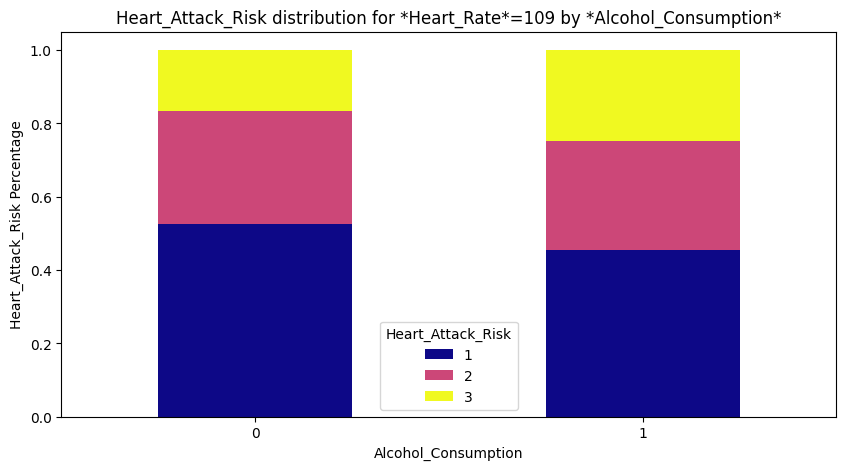

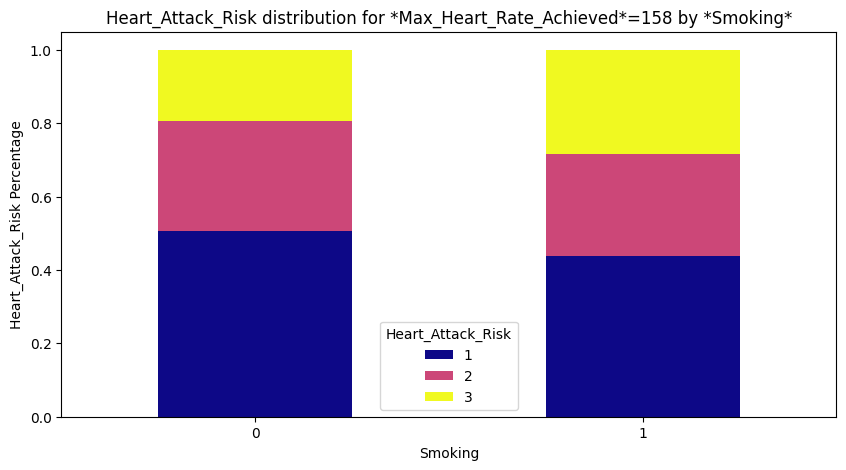

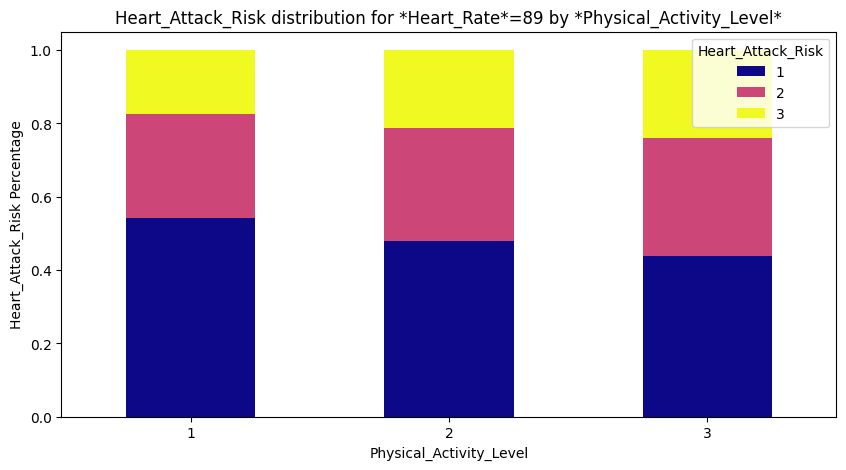

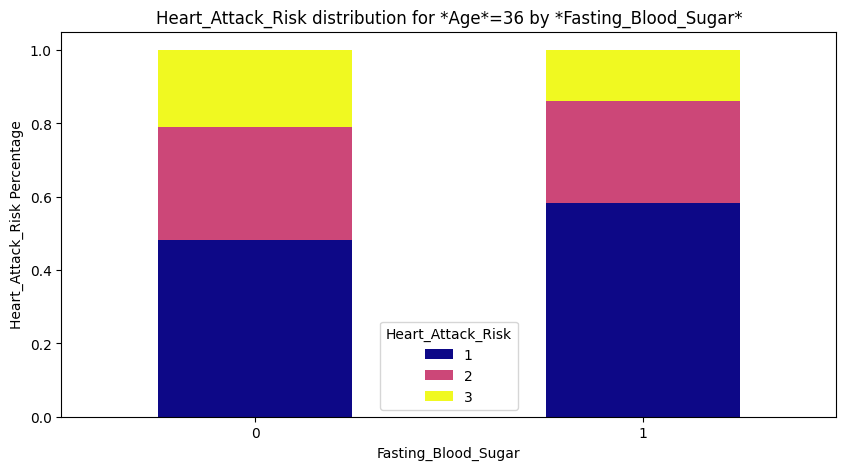

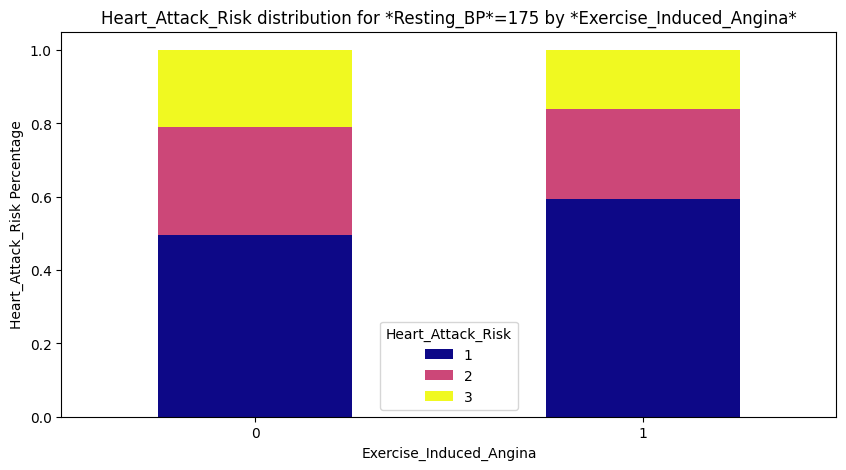

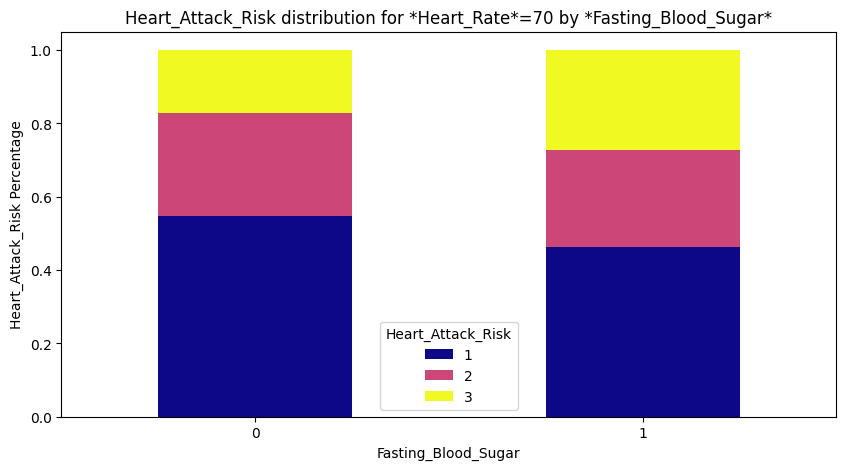

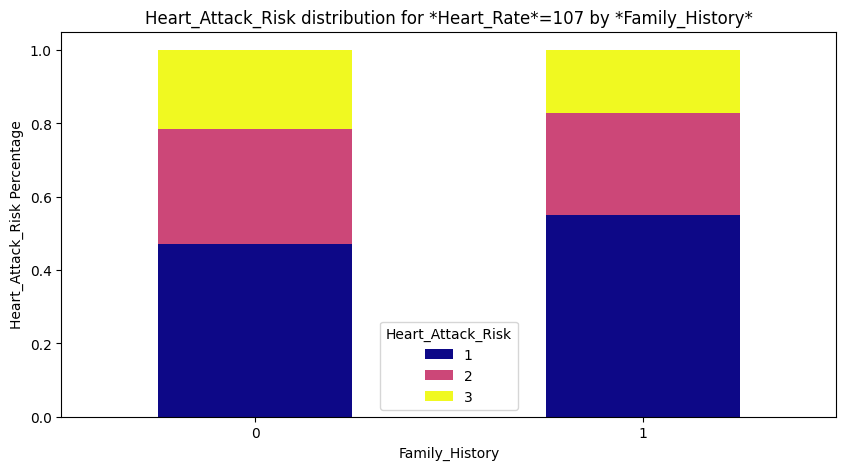

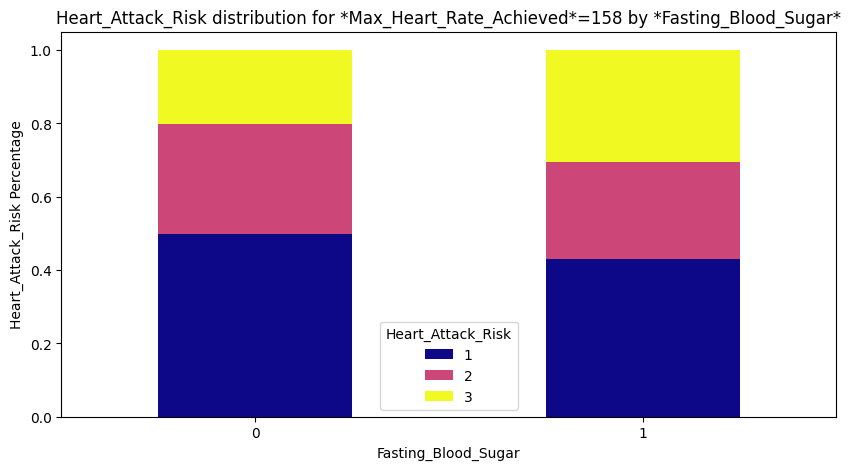

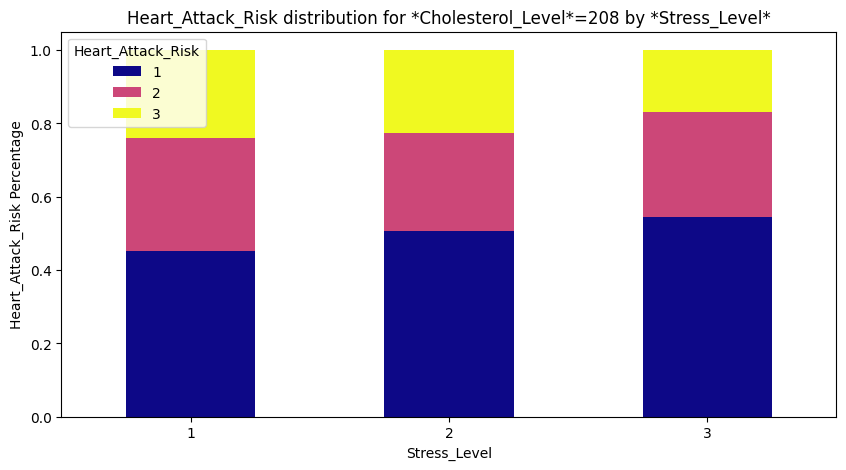

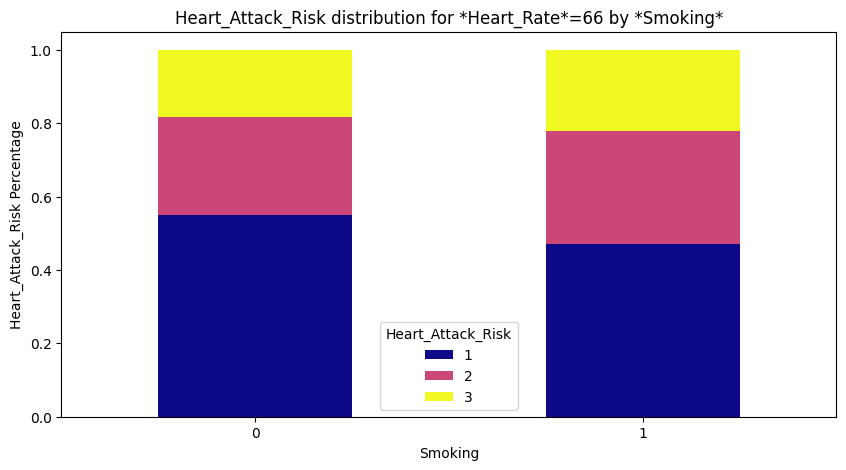

[(('Heart_Rate', 109, 'Alcohol_Consumption'), 0.0927077709862501),
 (('Max_Heart_Rate_Achieved', 158, 'Smoking'), 0.0857170689581462),
 (('Heart_Rate', 89, 'Physical_Activity_Level'), 0.08523305237482913),
 (('Age', 36, 'Fasting_Blood_Sugar'), -0.08040801066412415),
 (('Resting_BP', 175, 'Exercise_Induced_Angina'), -0.07978142361492778),
 (('Heart_Rate', 70, 'Fasting_Blood_Sugar'), 0.07975765231219456),
 (('Heart_Rate', 107, 'Family_History'), -0.0737527264515714),
 (('Max_Heart_Rate_Achieved', 158, 'Fasting_Blood_Sugar'),
  0.07302806367530763),
 (('Cholesterol_Level', 208, 'Stress_Level'), -0.07172613068745769),
 (('Heart_Rate', 66, 'Smoking'), 0.07135282995688359)]

In [306]:

top_k_subsets = get_top_k_subsets_highest_corr_optimized(binned_dataset, target_column)
show_bar_charts_highest_corr(binned_dataset, target_column, top_k_subsets)
top_k_subsets

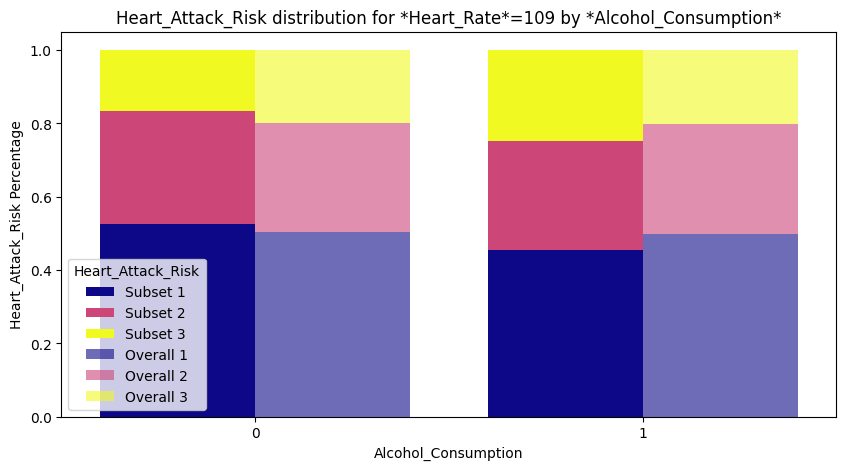

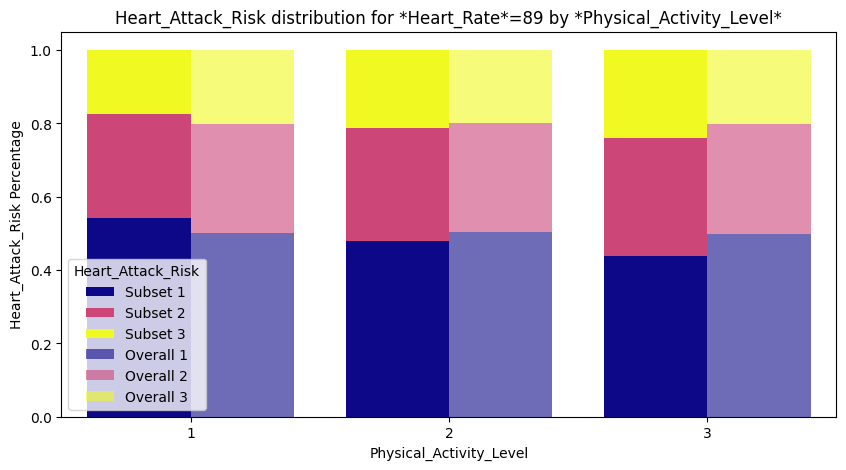

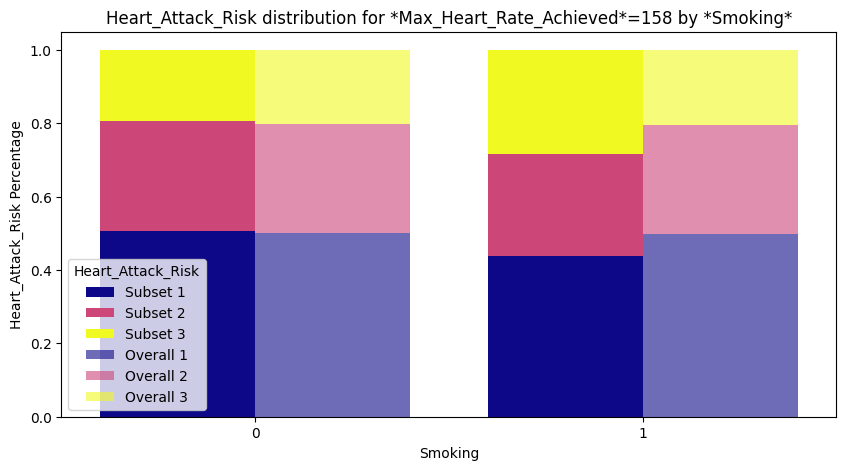

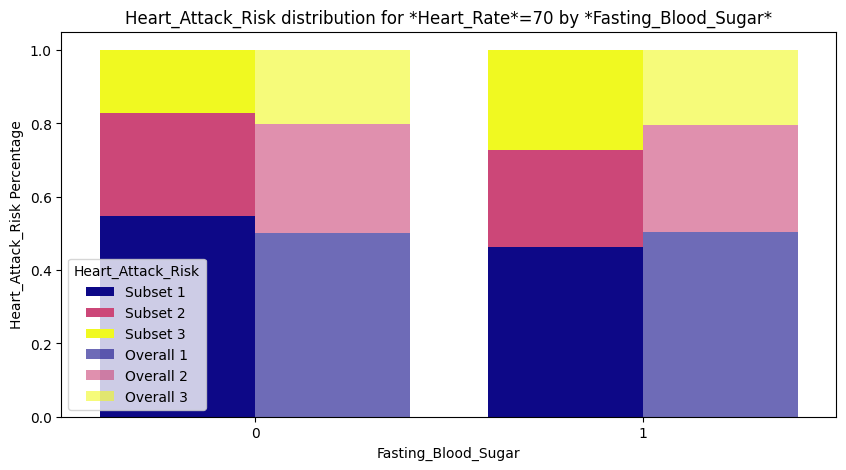

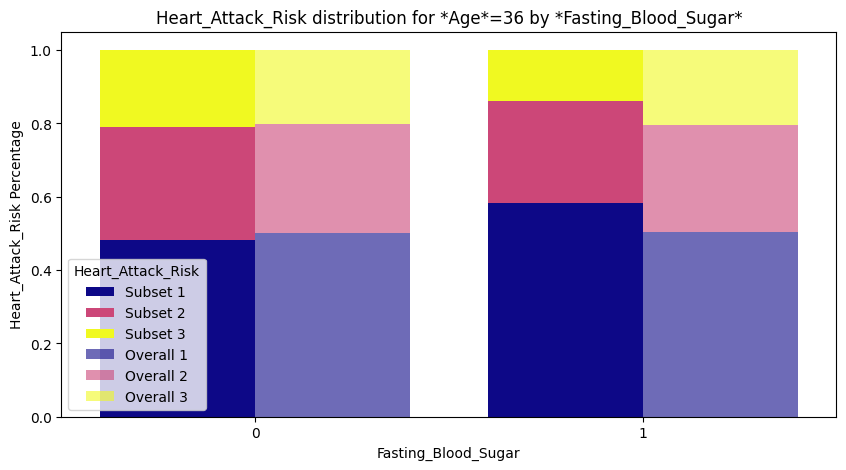

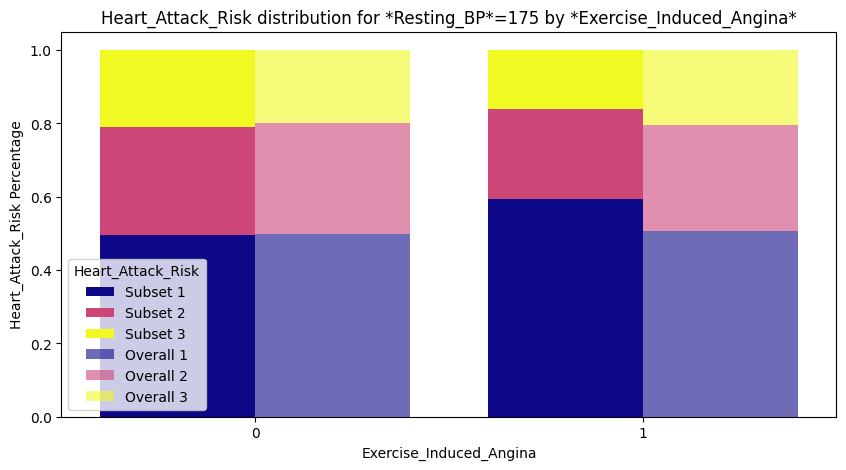

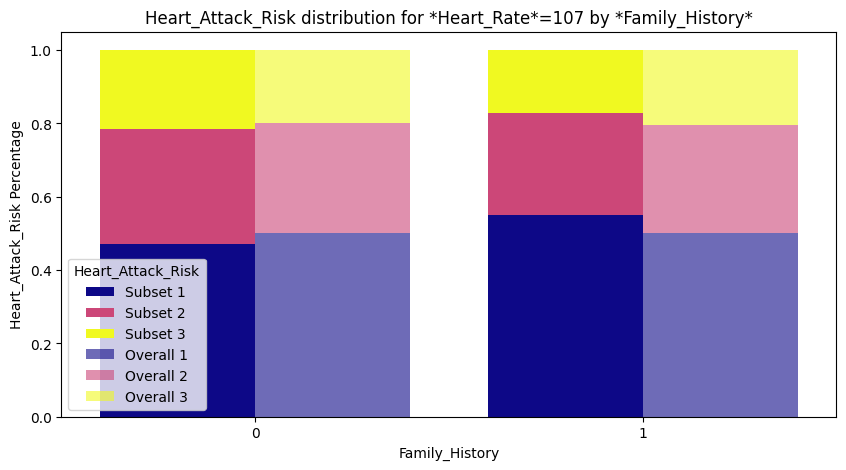

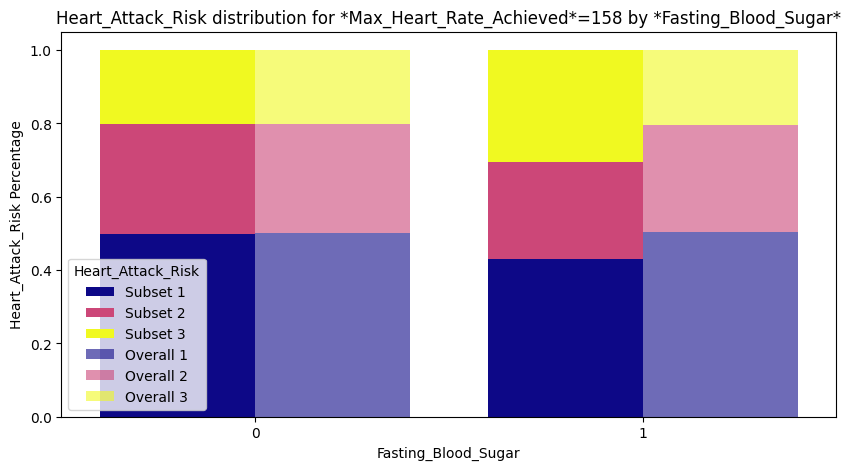

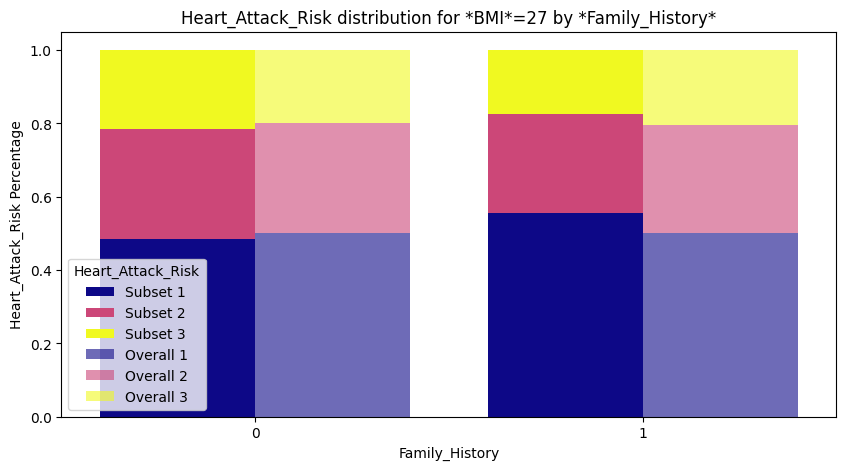

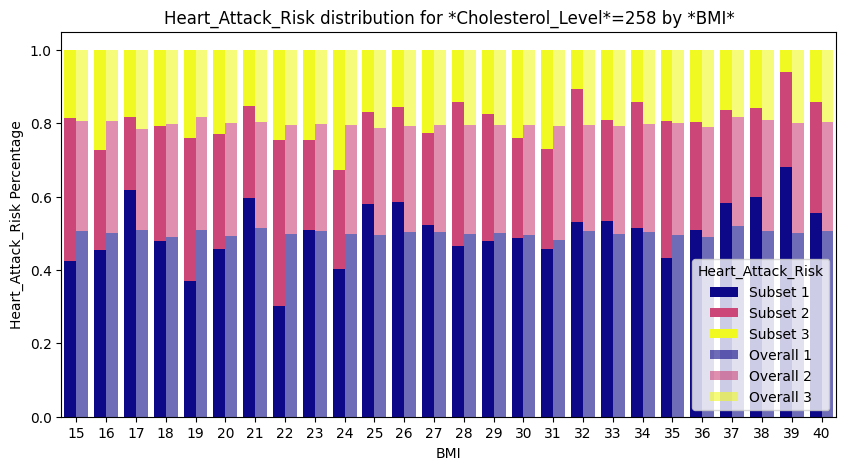

In [307]:

top_k_subsets = get_top_k_subsets_different_corr_optimized(binned_dataset, target_column, mode=ChosenColumnMode.HIGHEST_CORR)
show_bar_charts_different_corr(binned_dataset, target_column, top_k_subsets)

In [308]:

def is_correlated(dataset, column1, column2):
    """
    :param column1: dataframe column of the first feature
    :param column2: dataframe column of the second feature
    :return: chi-square correlation between the two features
    """

    # create a contingency table
    contingency_table = pd.crosstab(dataset[column1], dataset[column2])

    # calculate the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    return chi2, p, dof, expected


def cramers_v(x, y):
    # Ensure inputs are processed properly
    if isinstance(x, pd.Categorical):
        print("hi")
        x = x.codes
    if isinstance(y, pd.Categorical):
        y = y.codes
        print("hi")

    # Create a confusion matrix
    confusion_matrix = pd.crosstab(x, y)

    # Perform chi-square test
    chi2, _, _, _ = chi2_contingency(confusion_matrix)

    # Calculate Cramér's V
    n = confusion_matrix.sum().sum()  # Total number of observations
    r, k = confusion_matrix.shape  # Rows and columns of the matrix
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def theils_u(x, y):
    # Convert categorical data to numeric codes
    if isinstance(x, pd.Categorical):
        x = x.codes
    if isinstance(y, pd.Categorical):
        y = y.codes

    # Encode the variables
    le = LabelEncoder()
    x_encoded = le.fit_transform(pd.Series(x).dropna())
    y_encoded = le.fit_transform(pd.Series(y).dropna())
    
    # Joint and marginal probabilities
    joint_prob = pd.crosstab(x_encoded, y_encoded, normalize=True)
    x_prob = joint_prob.sum(axis=1)
    y_prob = joint_prob.sum(axis=0)
    
    # Entropy calculations
    h_x = -np.sum(x_prob * np.log2(x_prob + 1e-9))
    h_xy = -np.sum(joint_prob.values.flatten() * np.log2(joint_prob.values.flatten() + 1e-9))
    
    # Prevent division by zero and ensure positivity
    if h_x <= 0:
        return 0
    return max(0, (h_x - h_xy) / (h_x + 1e-9))

# is_correlated(binned_dataset, 'Age', 'Depression') 
# Calculate Cramér's V
# cramers_v_result = cramers_v(binned_dataset['Age'], binned_dataset['Depression'])
# print(f"Cramér's V Age & Depression: {cramers_v_result}")


# cramers_v_result = cramers_v(binned_dataset['Sleep Duration'], binned_dataset['Depression'])
# print(f"Cramér's V Sleep Duration & Depression: {cramers_v_result}")


# cramers_v_result = cramers_v(subset_age_18_20['Depression'], subset_age_18_20['Depression'])
# print(f"Cramér's V Sleep Duration & 17-18 VS. Depression: {cramers_v_result}")

# sleep_duration_map = {
#     'Less than 5 hours': 1,
#     '5-6 hours': 2,
#     '7-8 hours': 3,
#     'More than 8 hours': 4,
#     'Others': 5  # Or you can drop 'Others' if it doesn't make sense to assign a value
# }

# binned_dataset['Sleep_Duration_numeric'] = binned_dataset['Sleep Duration'].map(sleep_duration_map)

# correlation, p_value = spearmanr(binned_dataset['Sleep Duration'], binned_dataset['Depression'])
# print(f"Spearman's Rank Correlation between Sleep Duration and Depression: {correlation}")
# print(f"P-value: {p_value}")

# correlation = binned_dataset['Sleep_Duration_numeric'].corr(binned_dataset['Depression'])
# print(f"Pearson's Correlation between Age and Depression: {correlation}")

# theils_u_result = theils_u(binned_dataset['Age'], binned_dataset['Depression'])
# print(f"Theil's U (Age -> Depression): {theils_u_result}")


In [309]:
import matplotlib.pyplot as plt

def show_bar_chart_subsets(dataframe, column_subsets, target_column):
    for subset_value, subset_data in column_subsets.items():
        column_to_show = subset_data[target_column]
        
        # Bar chart configuration
        plt.title(f'{target_column} distribution for {subset_value}')
        plt.xlabel(target_column)
        plt.ylabel('Percentage')
        
        # Plot the bar chart
        value_counts = column_to_show.value_counts(normalize=True).sort_index()
        value_counts.plot(kind='bar', color=['royalblue', 'orange'])

        # Set x-ticks to 0 and 1
        rotation = 45
        if pd.api.types.is_numeric_dtype(column_to_show):
            rotation = 0
        plt.xticks(rotation=rotation)

        # Show the plot
        plt.show()

# Example usage
# subset_sleep_duration = create_subsets_for_column(binned_dataset, 'Have you ever had suicidal thoughts ?')

# show_bar_chart_subsets(binned_dataset, subset_sleep_duration, 'Depression')

# subset_age = create_subsets_for_column(binned_dataset, 'Age')

# show_bar_chart_subsets(binned_dataset, subset_age, 'Depression')
